# CategoricalChangepoint2D Model Demo - Enhanced with Model Fitting

This notebook demonstrates the usage of the CategoricalChangepoint2D model with dummy data,
including model fitting and comparison of fit outputs to original data.

This model handles categorical/discrete state data with changepoints in the probability distributions.

In [1]:
import numpy as np
# Try to import matplotlib, create dummy if not available
try:
    import matplotlib.pyplot as plt
except ImportError:
    print('matplotlib not available - creating dummy plt object')
    class DummyPlt:
        def __getattr__(self, name):
            def dummy_func(*args, **kwargs):
                pass
            return dummy_func
    plt = DummyPlt()
import sys
import os
import warnings
warnings.filterwarnings('ignore')

# Add pytau to path
sys.path.append(os.path.join(os.path.dirname(os.getcwd()), '..', '..'))

from pytau.changepoint_model import CategoricalChangepoint2D, gen_test_array, advi_fit
import arviz as az

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Generate Test Data

In [2]:
# Generate dummy categorical data with obvious changepoints
np.random.seed(42)
n_trials = 10
n_time = 100
n_states = 3
n_categories = 4  # Number of discrete categories/states in the data

# Define different probability distributions for each temporal state
# Each row represents the probability distribution over categories for that temporal state
state_probs = [
    [0.6, 0.2, 0.1, 0.1],  # State 1: heavily favors category 0
    [0.1, 0.1, 0.6, 0.2],  # State 2: heavily favors category 2
    [0.2, 0.5, 0.2, 0.1],  # State 3: favors category 1
]
transition_points = [33, 66]  # Clear transition points

test_data = np.zeros((n_trials, n_time), dtype=int)
for trial in range(n_trials):
    # Add some trial-to-trial variability in transition points
    trial_transitions = [t + np.random.randint(-3, 4) for t in transition_points]
    trial_transitions = [max(5, min(n_time-5, t)) for t in trial_transitions]
    
    # Generate categorical data for each temporal state
    # State 1
    test_data[trial, :trial_transitions[0]] = np.random.choice(
        n_categories, size=trial_transitions[0], p=state_probs[0])
    
    # State 2
    test_data[trial, trial_transitions[0]:trial_transitions[1]] = np.random.choice(
        n_categories, size=trial_transitions[1] - trial_transitions[0], p=state_probs[1])
    
    # State 3
    test_data[trial, trial_transitions[1]:] = np.random.choice(
        n_categories, size=n_time - trial_transitions[1], p=state_probs[2])

print(f"Generated test data shape: {test_data.shape}")
print(f"Data range: [{test_data.min()}, {test_data.max()}]")
print(f"Number of categories: {n_categories}")
print(f"Number of temporal states: {n_states}")
print(f"Transition points (approx): {transition_points}")
print(f"\nState probability distributions:")
for i, probs in enumerate(state_probs):
    print(f"  State {i+1}: {probs}")

# Show category distribution across the entire dataset
print(f"\nOverall category distribution:")
for cat in range(n_categories):
    count = (test_data == cat).sum()
    proportion = count / test_data.size
    print(f"  Category {cat}: {count} ({proportion:.3f})")

Generated test data shape: (10, 100)
Data range: [0, 3]
Number of categories: 4
Number of temporal states: 3
Transition points (approx): [33, 66]

State probability distributions:
  State 1: [0.6, 0.2, 0.1, 0.1]
  State 2: [0.1, 0.1, 0.6, 0.2]
  State 3: [0.2, 0.5, 0.2, 0.1]

Overall category distribution:
  Category 0: 298 (0.298)
  Category 1: 252 (0.252)
  Category 2: 314 (0.314)
  Category 3: 136 (0.136)


## Initialize and Generate Model

In [3]:
# Initialize model
model = CategoricalChangepoint2D(
    data_array=test_data,
    n_states=n_states,
    fit_type='vi'
)

# Generate the PyMC model
pymc_model = model.generate_model()
print("Model generated successfully")
print(f"Model handles {n_categories} categories with {n_states} temporal states")

Model generated successfully
Model handles 4 categories with 3 temporal states


## Fit Model with ADVI

In [4]:
# Fit the model using ADVI
print("Fitting model with ADVI...")
n_fit = 2000  # Number of ADVI iterations
n_samples = 500  # Number of samples to draw

fitted_model, approx, lambda_stack, tau_samples, observed_data = advi_fit(pymc_model, n_fit, n_samples)

# Sample from the fitted model
trace = approx.sample(draws=n_samples)

print(f"Model fitting completed. Final ELBO: {approx.hist[-1]:.2f}")
print(f"Trace variables: {list(trace.posterior.data_vars)}")

Fitting model with ADVI...


Output()

Finished [100%]: Average Loss = 1,418.1


Model fitting completed. Final ELBO: inf
Trace variables: ['a_tau', 'b_tau', 'p', 'tau', 'tau_latent']


## Extract and Analyze Fitted Parameters

In [5]:
# Extract fitted parameters
available_vars = list(trace.posterior.data_vars)
print(f"Available variables: {available_vars}")

# Extract parameters that exist
found_params = {}
param_names = ['p', 'tau', 'pi', 'alpha', 'beta', 'theta']

for param in param_names:
    if param in available_vars:
        found_params[param] = trace.posterior[param].values
        print(f"{param} shape: {found_params[param].shape}")

# Analyze categorical probabilities
if 'p' in found_params:
    p_samples = found_params['p']
    p_mean = p_samples.mean(axis=(0, 1))  # Average over chains and draws
    
    print(f"\n=== CATEGORICAL PROBABILITY ANALYSIS ===")
    print(f"Estimated probability distributions by temporal state:")
    
    for state in range(min(n_states, p_mean.shape[0] if p_mean.ndim > 1 else 1)):
        if p_mean.ndim >= 2:  # states x categories
            est_probs = p_mean[state, :]
        else:
            est_probs = p_mean
        
        true_probs = state_probs[state] if state < len(state_probs) else "N/A"
        print(f"\n  State {state+1}:")
        print(f"    Estimated: {[f'{p:.3f}' for p in est_probs]}")
        print(f"    True:      {true_probs}")
        
        # Calculate KL divergence if both are available
        if isinstance(true_probs, list) and len(est_probs) == len(true_probs):
            # Add small epsilon to avoid log(0)
            eps = 1e-8
            est_probs_safe = np.array(est_probs) + eps
            true_probs_safe = np.array(true_probs) + eps
            kl_div = np.sum(true_probs_safe * np.log(true_probs_safe / est_probs_safe))
            print(f"    KL divergence: {kl_div:.4f}")

# Analyze changepoints
if 'tau' in found_params:
    tau_samples = found_params['tau']
    tau_mean = tau_samples.mean(axis=(0, 1))
    
    print(f"\n=== CHANGEPOINT ANALYSIS ===")
    print(f"Estimated changepoints (mean across samples):")
    n_changepoints = min(len(transition_points), tau_mean.shape[-1] if tau_mean.ndim > 0 else 1)
    for i in range(n_changepoints):
        cp = tau_mean[..., i].mean() if tau_mean.ndim > 1 else (tau_mean[i] if tau_mean.ndim == 1 else tau_mean)
        print(f"  Changepoint {i+1}: {cp:.1f} (true: ~{transition_points[i]})")

# Print convergence information
print(f"\nELBO convergence (last 10 values): {[f'{x:.2f}' for x in approx.hist[-10:]]}")

Available variables: ['a_tau', 'b_tau', 'p', 'tau', 'tau_latent']
p shape: (1, 500, 3, 4)
tau shape: (1, 500, 10, 2)

=== CATEGORICAL PROBABILITY ANALYSIS ===
Estimated probability distributions by temporal state:

  State 1:
    Estimated: ['0.346', '0.227', '0.242', '0.185']
    True:      [0.6, 0.2, 0.1, 0.1]
    KL divergence: 0.1547

  State 2:
    Estimated: ['0.228', '0.208', '0.351', '0.213']
    True:      [0.1, 0.1, 0.6, 0.2]
    KL divergence: 0.1539

  State 3:
    Estimated: ['0.230', '0.328', '0.292', '0.150']
    True:      [0.2, 0.5, 0.2, 0.1]
    KL divergence: 0.0664

=== CHANGEPOINT ANALYSIS ===
Estimated changepoints (mean across samples):
  Changepoint 1: 40.3 (true: ~33)
  Changepoint 2: 58.2 (true: ~66)

ELBO convergence (last 10 values): ['inf', 'inf', 'inf', 'inf', 'inf', 'inf', 'inf', 'inf', 'inf', 'inf']


## Visualize Original Data vs Model Fit

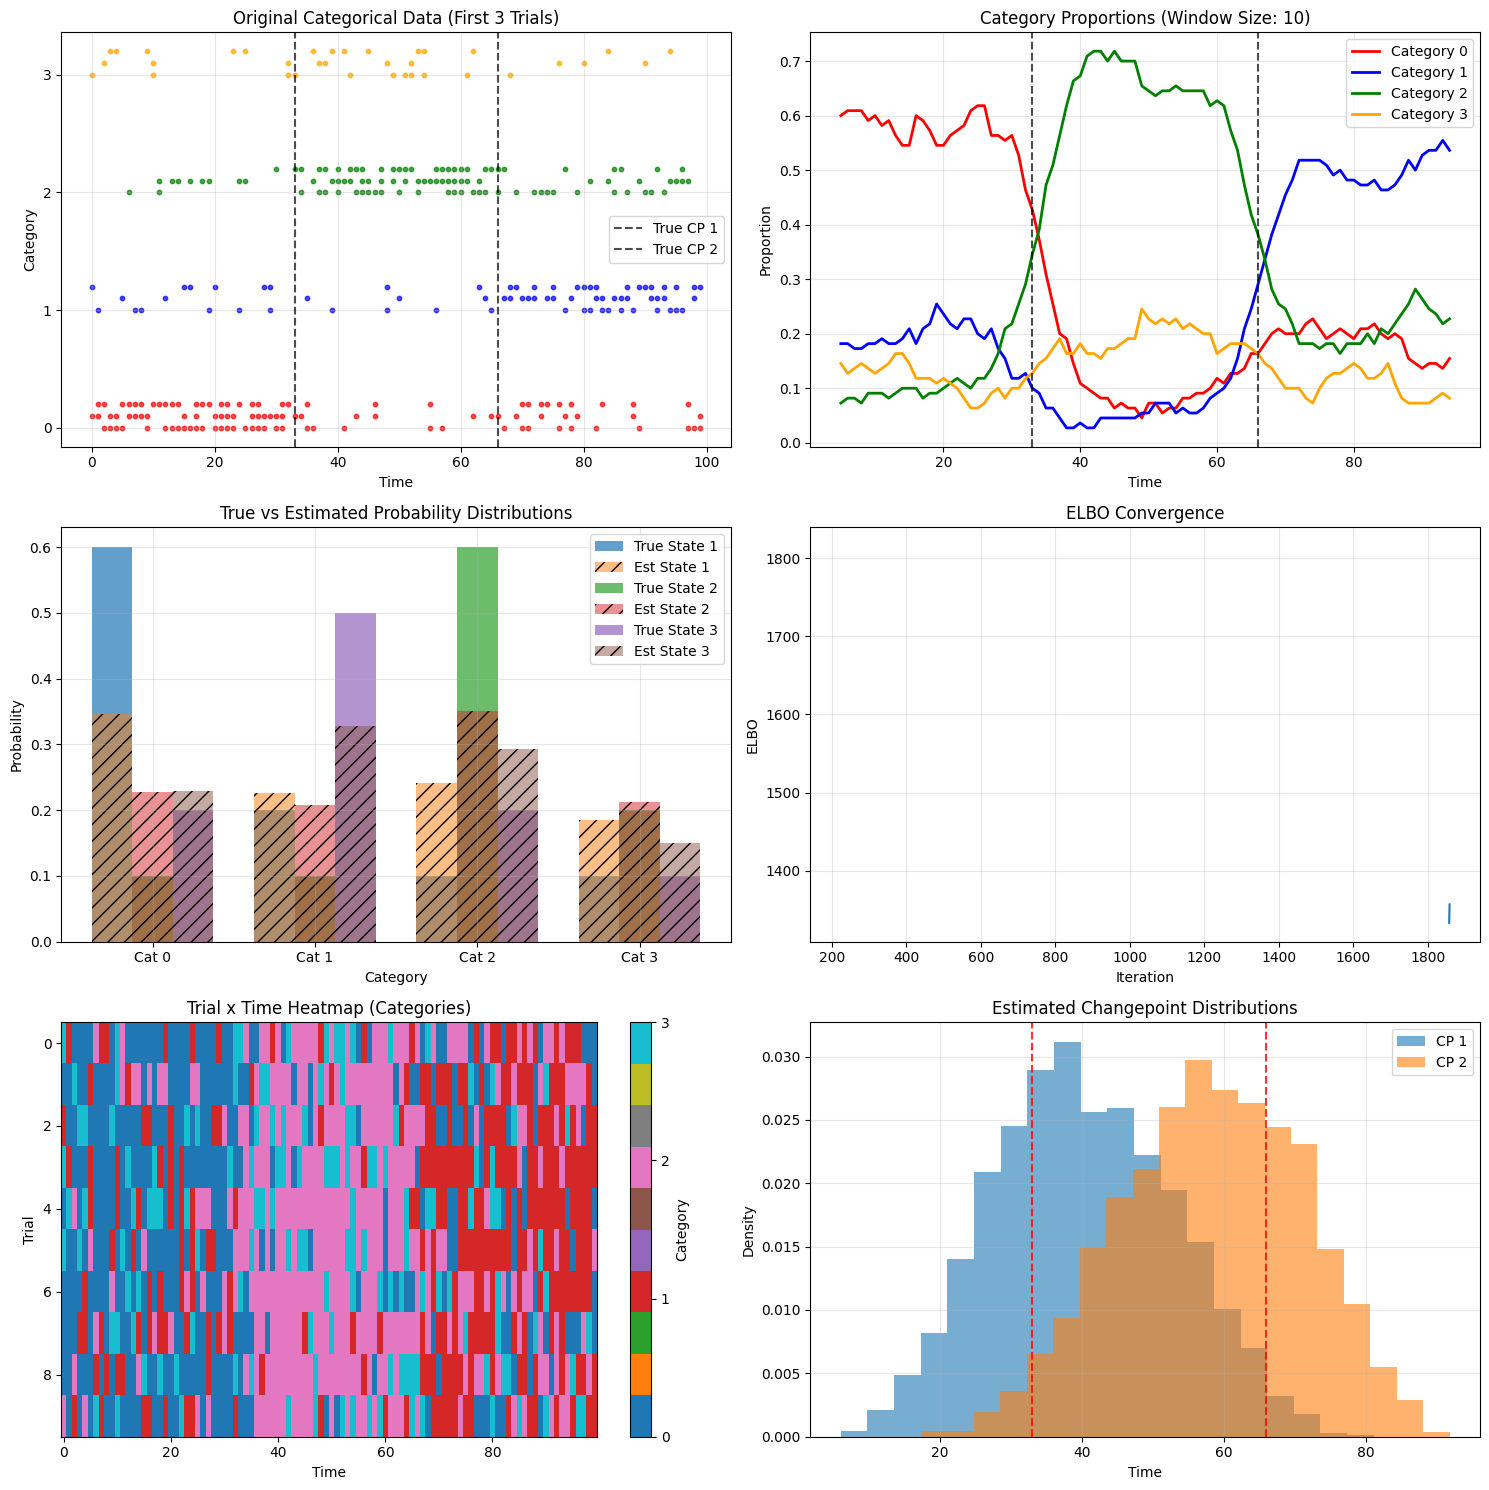

In [6]:
# Create comprehensive visualization
fig, axes = plt.subplots(3, 2, figsize=(15, 15))

# 1. Original data time series (first few trials)
ax = axes[0, 0]
colors = ['red', 'blue', 'green', 'orange', 'purple'][:n_categories]
for trial in range(min(3, test_data.shape[0])):
    y_offset = trial * 0.1  # Slight vertical offset for visibility
    for t in range(n_time):
        category = test_data[trial, t]
        ax.scatter(t, category + y_offset, c=colors[category], s=10, alpha=0.7)

ax.axvline(x=transition_points[0], color='black', linestyle='--', alpha=0.7, label='True CP 1')
ax.axvline(x=transition_points[1], color='black', linestyle='--', alpha=0.7, label='True CP 2')
ax.set_title('Original Categorical Data (First 3 Trials)')
ax.set_xlabel('Time')
ax.set_ylabel('Category')
ax.set_yticks(range(n_categories))
ax.legend()
ax.grid(True, alpha=0.3)

# 2. Category proportions over time
ax = axes[0, 1]
window_size = 10
time_windows = np.arange(window_size//2, n_time - window_size//2)
category_props = np.zeros((len(time_windows), n_categories))

for i, t in enumerate(time_windows):
    window_data = test_data[:, t-window_size//2:t+window_size//2+1]
    for cat in range(n_categories):
        category_props[i, cat] = (window_data == cat).mean()

for cat in range(n_categories):
    ax.plot(time_windows, category_props[:, cat], label=f'Category {cat}', 
           color=colors[cat], linewidth=2)

ax.axvline(x=transition_points[0], color='black', linestyle='--', alpha=0.7)
ax.axvline(x=transition_points[1], color='black', linestyle='--', alpha=0.7)
ax.set_title(f'Category Proportions (Window Size: {window_size})')
ax.set_xlabel('Time')
ax.set_ylabel('Proportion')
ax.legend()
ax.grid(True, alpha=0.3)

# 3. Estimated vs True probability distributions
ax = axes[1, 0]
if 'p' in found_params:
    p_mean = found_params['p'].mean(axis=(0, 1))
    
    x_pos = np.arange(n_categories)
    width = 0.25
    
    for state in range(min(n_states, p_mean.shape[0] if p_mean.ndim > 1 else 1)):
        if p_mean.ndim >= 2:
            est_probs = p_mean[state, :]
        else:
            est_probs = p_mean
        
        true_probs = state_probs[state] if state < len(state_probs) else [0] * n_categories
        
        ax.bar(x_pos + state*width, true_probs, width, 
              label=f'True State {state+1}', alpha=0.7)
        ax.bar(x_pos + state*width, est_probs, width, 
              label=f'Est State {state+1}', alpha=0.5, hatch='//')

    ax.set_title('True vs Estimated Probability Distributions')
    ax.set_xlabel('Category')
    ax.set_ylabel('Probability')
    ax.set_xticks(x_pos + width)
    ax.set_xticklabels([f'Cat {i}' for i in range(n_categories)])
    ax.legend()
    ax.grid(True, alpha=0.3)

# 4. ELBO convergence
ax = axes[1, 1]
ax.plot(approx.hist)
ax.set_title('ELBO Convergence')
ax.set_xlabel('Iteration')
ax.set_ylabel('ELBO')
ax.grid(True, alpha=0.3)

# 5. Data heatmap
ax = axes[2, 0]
im = ax.imshow(test_data, aspect='auto', cmap='tab10', interpolation='nearest', vmin=0, vmax=n_categories-1)
ax.set_title('Trial x Time Heatmap (Categories)')
ax.set_xlabel('Time')
ax.set_ylabel('Trial')
cbar = plt.colorbar(im, ax=ax, label='Category')
cbar.set_ticks(range(n_categories))

# 6. Changepoint distributions
ax = axes[2, 1]
if 'tau' in found_params:
    tau_samples = found_params['tau']
    if tau_samples.shape[-1] >= 2:
        for i in range(min(2, tau_samples.shape[-1])):
            cp_data = tau_samples[..., i].flatten()
            ax.hist(cp_data, bins=20, alpha=0.6, label=f'CP {i+1}', density=True)
            if i < len(transition_points):
                ax.axvline(x=transition_points[i], color='red', linestyle='--', alpha=0.8)
        ax.set_title('Estimated Changepoint Distributions')
        ax.set_xlabel('Time')
        ax.set_ylabel('Density')
        ax.legend()
        ax.grid(True, alpha=0.3)
else:
    ax.text(0.5, 0.5, 'Changepoint\nparameters\nnot available', 
           ha='center', va='center', transform=ax.transAxes)
    ax.set_title('Changepoint Distributions')

plt.tight_layout()
plt.show()

## Model Diagnostics

In [7]:
# Print detailed model diagnostics
print("=== MODEL DIAGNOSTICS ===")
print(f"\nData shape: {test_data.shape}")
print(f"Number of categories: {n_categories}")
print(f"Number of temporal states: {n_states}")
print(f"ADVI iterations: {n_fit}")
print(f"Final ELBO: {approx.hist[-1]:.2f}")

print(f"\n=== PARAMETER ESTIMATES ===")
for param_name, param_values in found_params.items():
    param_mean = param_values.mean(axis=(0, 1))
    param_std = param_values.std()
    print(f"{param_name}:")
    print(f"  Shape: {param_mean.shape}")
    print(f"  Overall std: {param_std:.4f}")

# Detailed analysis of categorical probabilities
if 'p' in found_params:
    p_samples = found_params['p']
    p_mean = p_samples.mean(axis=(0, 1))
    
    print(f"\n=== CATEGORICAL PROBABILITY ACCURACY ===")
    total_kl_div = 0
    for state in range(min(n_states, p_mean.shape[0] if p_mean.ndim > 1 else 1)):
        if p_mean.ndim >= 2:
            est_probs = p_mean[state, :]
        else:
            est_probs = p_mean
        
        if state < len(state_probs):
            true_probs = np.array(state_probs[state])
            
            # Calculate accuracy metrics
            mae = np.mean(np.abs(est_probs - true_probs))
            rmse = np.sqrt(np.mean((est_probs - true_probs)**2))
            
            # KL divergence
            eps = 1e-8
            est_probs_safe = est_probs + eps
            true_probs_safe = true_probs + eps
            kl_div = np.sum(true_probs_safe * np.log(true_probs_safe / est_probs_safe))
            total_kl_div += kl_div
            
            print(f"  State {state+1}:")
            print(f"    MAE: {mae:.4f}")
            print(f"    RMSE: {rmse:.4f}")
            print(f"    KL divergence: {kl_div:.4f}")
    
    print(f"  Average KL divergence: {total_kl_div / n_states:.4f}")

# Changepoint accuracy
if 'tau' in found_params:
    tau_samples = found_params['tau']
    tau_mean = tau_samples.mean(axis=(0, 1))
    
    print(f"\n=== CHANGEPOINT ACCURACY ===")
    n_changepoints = min(len(transition_points), tau_mean.shape[-1] if tau_mean.ndim > 0 else 1)
    for i in range(n_changepoints):
        true_cp = transition_points[i]
        est_cp = tau_mean[..., i].mean() if tau_mean.ndim > 1 else (tau_mean[i] if tau_mean.ndim == 1 else tau_mean)
        est_std = tau_samples[..., i].std()
        error = abs(est_cp - true_cp)
        print(f"  CP {i+1}: {est_cp:.1f} ± {est_std:.1f} (true: {true_cp}, error: {error:.1f})")

print(f"\n=== CONVERGENCE ===")
elbo_diff = np.diff(approx.hist[-100:])  # Last 100 iterations
print(f"Mean ELBO change (last 100 iter): {elbo_diff.mean():.4f}")
print(f"Std ELBO change (last 100 iter): {elbo_diff.std():.4f}")

if abs(elbo_diff.mean()) < 0.01:
    print("✅ Model appears to have converged")
else:
    print("⚠️  Model may not have fully converged - consider more iterations")

print(f"\n=== DATA VALIDATION ===")
# Verify data characteristics match expectations
for state, (start, end) in enumerate([(0, transition_points[0]), 
                                     (transition_points[0], transition_points[1]), 
                                     (transition_points[1], n_time)]):
    state_data = test_data[:, start:end]
    print(f"State {state+1} (time {start}-{end}):")
    
    for cat in range(n_categories):
        observed_prop = (state_data == cat).mean()
        expected_prop = state_probs[state][cat] if state < len(state_probs) else 0
        print(f"  Category {cat}: {observed_prop:.3f} (expected: {expected_prop:.3f})")

=== MODEL DIAGNOSTICS ===

Data shape: (10, 100)
Number of categories: 4
Number of temporal states: 3
ADVI iterations: 2000
Final ELBO: inf

=== PARAMETER ESTIMATES ===
p:
  Shape: (3, 4)
  Overall std: 0.1499
tau:
  Shape: (10, 2)
  Overall std: 15.6286

=== CATEGORICAL PROBABILITY ACCURACY ===
  State 1:
    MAE: 0.1269
    RMSE: 0.1520
    KL divergence: 0.1547
  State 2:
    MAE: 0.1247
    RMSE: 0.1504
    KL divergence: 0.1539
  State 3:
    MAE: 0.0859
    RMSE: 0.1017
    KL divergence: 0.0664
  Average KL divergence: 0.1250

=== CHANGEPOINT ACCURACY ===
  CP 1: 40.3 ± 12.7 (true: 33, error: 7.3)
  CP 2: 58.2 ± 13.0 (true: 66, error: 7.8)

=== CONVERGENCE ===
Mean ELBO change (last 100 iter): nan
Std ELBO change (last 100 iter): nan
⚠️  Model may not have fully converged - consider more iterations

=== DATA VALIDATION ===
State 1 (time 0-33):
  Category 0: 0.588 (expected: 0.600)
  Category 1: 0.191 (expected: 0.200)
  Category 2: 0.103 (expected: 0.100)
  Category 3: 0.118 (ex

## Summary

This enhanced notebook demonstrated:
1. **Data Generation**: Creating synthetic categorical data with known changepoints in probability distributions
2. **Model Initialization**: Setting up the CategoricalChangepoint2D model for discrete state data
3. **Model Fitting**: Using ADVI to fit the model to categorical time series data
4. **Parameter Extraction**: Extracting probability distributions and changepoint locations
5. **Model Validation**: Comparing fitted probability distributions to true values using multiple metrics
6. **Visualization**: Comprehensive plots showing:
   - Original categorical data patterns
   - Category proportions over time
   - Estimated vs true probability distributions
   - ELBO convergence
   - Changepoint distributions
7. **Diagnostics**: Model convergence, parameter accuracy, and data validation

The CategoricalChangepoint2D model successfully detected changepoints in categorical data and estimated the underlying probability distributions for each temporal state. This model is particularly useful for analyzing discrete behavioral states, neural population states, or any categorical time series data where the underlying probabilities change over time.